In [ ]:
import itertools
import os
from os import path as pt

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from hyperparameters import SIGCWGAN_CONFIGS
from lib import ALGOS
from lib.algos.base import BaseConfig
from lib.data import download_man_ahl_dataset, download_mit_ecg_dataset
from lib.data import get_data
from lib.plot import savefig, create_summary
from lib.utils import pickle_it

import argparse

In [ ]:
# Necessary functions to retrieve model's configuration
def get_algo_config(dataset, data_params):
    """ Get the algorithms parameters. """
    key = dataset
    if dataset == 'VAR':
        key += str(data_params['dim'])
    elif dataset == 'STOCKS':
        key += '_' + '_'.join(data_params['assets'])
    return SIGCWGAN_CONFIGS[key]

def get_algo(algo_id, base_config, dataset, data_params, x_real):
    if algo_id == 'SigCWGAN':
        algo_config = get_algo_config(dataset, data_params)
        algo = ALGOS[algo_id](x_real=x_real, config=algo_config, base_config=base_config)
    else:
        algo = ALGOS[algo_id](x_real=x_real, base_config=base_config)
    return algo

In [ ]:
# Auxiliary classes to preprocess data
class Pipeline:
    def __init__(self, steps):
        """ Pre- and postprocessing pipeline. """
        self.steps = steps

    def transform(self, x, until=None):
        x = x.clone()
        for n, step in self.steps:
            if n == until:
                break
            x = step.transform(x)
        return x

    def inverse_transform(self, x, until=None):
        for n, step in self.steps[::-1]:
            if n == until:
                break
            x = step.inverse_transform(x)
        return x


class StandardScalerTS():
    """ Standard scales a given (indexed) input vector along the specified axis. """

    def __init__(self, axis=(1)):
#     def __init__(self, axis=(0,1)):
        self.mean = None
        self.std = None
#         self.std = torch.Tensor([1.0])
        self.axis = axis

    def transform(self, x):
        if self.mean is None:
            self.mean = torch.mean(x, dim=self.axis)
            self.std = torch.std(x, dim=self.axis)
        return (x - self.mean.to(x.device)) / self.std.to(x.device)
#         return (x - self.mean.to(x.device))

    def inverse_transform(self, x):
#         return x + self.mean.to(x.device)
        return x * self.std.to(x.device) + self.mean.to(x.device)
    
def rolling_window(x, x_lag, add_batch_dim=True):
    if add_batch_dim:
        x = x[None, ...]
    return torch.cat([x[:, t:t + x_lag] for t in range(x.shape[1] - x_lag)], dim=0)

In [ ]:
# Data loading (stock prices)
data_path = r"/mnt/c/Users/hugom/OneDrive/Documentos/ETHZ academic/Project/Code/Data_extraction/data500SP_v1.csv"

data1 = pd.read_csv(data_path, index_col=0, header=[0,1])
data1.index = pd.to_datetime(data1.index)

log_returns = data1['Adj Close'].div(data1['Adj Close'].shift(periods=1)).apply(np.log)[1:]
log_returns = log_returns[["GOOG"]]

print(log_returns[log_returns.columns[:2]])

In [ ]:
x = log_returns[log_returns.columns[:]].to_numpy().T
data_raw = torch.from_numpy(x).float().unsqueeze(2)
print("data_raw shape", data_raw.shape)
print("data_raw", data_raw)

In [ ]:
# Setting of past and future window values
p = 3
q = 3
print(p,q)
len_pq_stock = len_stock - (p + q)
print("len_pq_stock", len_pq_stock)

In [ ]:
# Preprocessing of data
pipeline = Pipeline(steps=[('standard_scale', StandardScalerTS(axis=(0, 1)))])
data_preprocessed = pipeline.transform(data_raw)
xi_list = []
for i in range(data_preprocessed.shape[0]):
    xi_real = rolling_window(data_preprocessed[i], p + q)
    xi_list.append(xi_real)

x_real = torch.cat(xi_list, 0)
print("x_real shape", x_real.shape)

In [ ]:
# Specification of options to run appropiate experiment
parser = argparse.ArgumentParser()
# Meta parameters
parser.add_argument('-base_dir', default='./numerical_results', type=str)
# parser.add_argument('-use_cuda', action='store_true')
parser.add_argument('-use_cuda', default=True)
# parser.add_argument('-device', default=1, type=int)
parser.add_argument('-device', default=0, type=int)
parser.add_argument('-num_seeds', default=1, type=int)
parser.add_argument('-initial_seed', default=0, type=int)
#parser.add_argument('-datasets', default=['ARCH', 'STOCKS', 'ECG', 'VAR', ], nargs="+")
parser.add_argument('-datasets', default=['STOCKS', 'ARCH', 'VAR', ], nargs="+")
parser.add_argument('-algos', default=['SigCWGAN', 'GMMN', 'RCGAN', 'TimeGAN', 'RCWGAN', 'CWGAN',], nargs="+")


# Algo hyperparameters
parser.add_argument('-batch_size', default=200, type=int)
parser.add_argument('-p', default=p, type=int)
parser.add_argument('-q', default=q, type=int)
parser.add_argument('-hidden_dims', default=3 * (50,), type=tuple)
parser.add_argument('-total_steps', default=2000, type=int)

args = parser.parse_args('')

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

n_seeds=1

seeds = list(range(n_seeds))

seed = seeds[0]
print(seed)
base_config = BaseConfig(
    device='cuda:{}'.format(args.device) if args.use_cuda and torch.cuda.is_available() else 'cpu',
    seed=seed,
    batch_size=args.batch_size,
    hidden_dims=args.hidden_dims,
    p=args.p,
    q=args.q,
    total_steps=args.total_steps,
    mc_samples=2000,
)
set_seed(seed)

dataset = 'STOCKS'

# generator = get_dataset_configuration(dataset)
spec, data_params = 'SPX', {'assets': ('SPX',)}

algo_id='SigCWGAN'
# base_config=base_config
# data_params=data_params
# dataset=dataset
base_dir=args.base_dir
# spec=spec

In [ ]:
# A check to verify if it is using the desired device
base_config.device

In [ ]:
# Loading data to processing device
x_real = x_real.to(base_config.device)
print(base_config.device)
print("x_real shape", x_real.shape)

In [ ]:
""" Create the experiment directory, calibrate algorithm, store relevant parameters. """
print('Executing: %s, %s, %s' % (algo_id, dataset, spec))
experiment_directory = pt.join(base_dir, dataset, spec, 'seed={}'.format(base_config.seed), algo_id)
if not pt.exists(experiment_directory):
    # if the experiment directory does not exist we create the directory
    os.makedirs(experiment_directory)
# Set seed for exact reproducibility of the experiments
set_seed(base_config.seed)
# initialise dataset and algo

# Setting the portion of training data and start of training
ind_train = int(x_real.shape[0] * 0.8)
x_real_train, x_real_test = x_real[:ind_train], x_real[ind_train:] #train_test_split(x_real, train_size = 0.8)
# x_real_train, x_real_test = x_real, x_real

algo = get_algo(algo_id, base_config, dataset, data_params, x_real_train)
print(algo)
# Train the algorithm
algo.fit()

In [ ]:
# Functions used to plot some results, even though the obtained plots were not the ones considered for the report of the semester project

from os.path import join

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from lib.test_metrics import *
from lib.utils import to_numpy


def set_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


def compare_hists(x_real, x_fake, ax=None, log=False, label=None):
    """ Computes histograms and plots those. """
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if label is not None:
        label_historical = 'Historical ' + label
        label_generated = 'Generated ' + label
    else:
        label_historical = 'Historical'
        label_generated = 'Generated'
    bin_edges = ax.hist(x_real.flatten(), bins=80, alpha=0.6, density=True, label=label_historical)[1]
    ax.hist(x_fake.flatten(), bins=bin_edges, alpha=0.6, density=True, label=label_generated)
    ax.grid()
    set_style(ax)
    ax.legend()
    if log:
        ax.set_ylabel('log-pdf')
        ax.set_yscale('log')
    else:
        ax.set_ylabel('pdf')
    return ax


def compare_acf(x_real, x_fake, ax=None, max_lag=64, CI=True, dim=(0, 1), drop_first_n_lags=0):
    """ Computes ACF of historical and (mean)-ACF of generated and plots those. """
    if ax is None:
        _, ax = plt.subplots(1, 1)
    acf_real_list = cacf_torch(x_real, max_lag=max_lag, dim=dim).cpu().numpy()
    acf_real = np.mean(acf_real_list, axis=0)

    acf_fake_list = cacf_torch(x_fake, max_lag=max_lag, dim=dim).cpu().numpy()
    acf_fake = np.mean(acf_fake_list, axis=0)

    ax.plot(acf_real[drop_first_n_lags:], label='Historical')
    ax.plot(acf_fake[drop_first_n_lags:], label='Generated', alpha=0.8)

    if CI:
        acf_fake_std = np.std(acf_fake_list, axis=0)
        ub = acf_fake + acf_fake_std
        lb = acf_fake - acf_fake_std

        for i in range(acf_real.shape[-1]):
            ax.fill_between(
                range(acf_fake[:, i].shape[0]),
                ub[:, i], lb[:, i],
                color='orange',
                alpha=.3
            )
    set_style(ax)
    ax.set_xlabel('Lags')
    ax.set_ylabel('ACF')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True)
    ax.legend()
    return ax


def plot_summary(x_fake, x_real, max_lag=None, labels=None):
    if max_lag is None:
        max_lag = min(128, x_fake.shape[1])

    from lib.test_metrics import skew_torch, kurtosis_torch
    dim = x_real.shape[2]
    _, axes = plt.subplots(dim, 3, figsize=(25, dim * 5))

    if len(axes.shape) == 1:
        axes = axes[None, ...]
    for i in range(dim):
        x_real_i = x_real[..., i:i + 1]
        x_fake_i = x_fake[..., i:i + 1]

        compare_hists(x_real=to_numpy(x_real_i), x_fake=to_numpy(x_fake_i), ax=axes[i, 0])

        def text_box(x, height, title):
            textstr = '\n'.join((
                r'%s' % (title,),
                # t'abs_metric=%.2f' % abs_metric
                r'$s=%.2f$' % (skew_torch(x).item(),),
                r'$\kappa=%.2f$' % (kurtosis_torch(x).item(),))
            )
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            axes[i, 0].text(
                0.05, height, textstr,
                transform=axes[i, 0].transAxes,
                fontsize=14,
                verticalalignment='top',
                bbox=props
            )

        text_box(x_real_i, 0.95, 'Historical')
        text_box(x_fake_i, 0.70, 'Generated')

        compare_hists(x_real=to_numpy(x_real_i), x_fake=to_numpy(x_fake_i), ax=axes[i, 1], log=True)
        compare_acf(x_real=x_real_i, x_fake=x_fake_i, ax=axes[i, 2], max_lag=max_lag, CI=False, dim=(0, 1))


def compare_cross_corr(x_real, x_fake):
    """ Computes cross correlation matrices of x_real and x_fake and plots them. """
    x_real = x_real.reshape(-1, x_real.shape[2])
    x_fake = x_fake.reshape(-1, x_fake.shape[2])
    cc_real = np.corrcoef(to_numpy(x_real).T)
    cc_fake = np.corrcoef(to_numpy(x_fake).T)

    vmin = min(cc_fake.min(), cc_real.min())
    vmax = max(cc_fake.max(), cc_real.max())

    fig, axes = plt.subplots(1, 2)
    axes[0].matshow(cc_real, vmin=vmin, vmax=vmax)
    im = axes[1].matshow(cc_fake, vmin=vmin, vmax=vmax)

    axes[0].set_title('Real')
    axes[1].set_title('Generated')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)


def plot_signature(signature_tensor, alpha=0.2):
    plt.plot(to_numpy(signature_tensor).T, alpha=alpha, linestyle='None', marker='o')
    plt.grid()


def savefig(filename, directory):
    plt.savefig(join(directory, filename))
    plt.close()


def create_summary(dataset, device, G, lags_past, steps, x_real, one=False):
    print("lags_past", lags_past)
    print("x_real shape", x_real.shape)
    print("x_real", x_real[:3,:,:])
    with torch.no_grad():
        x_past = x_real[:, :lags_past]
        print("x_past", x_past)
        if dataset in ['STOCKS', 'ECG']:
            x_p = x_past.clone().repeat(5, 1, 1)
            print("x_p shape", x_p.shape)
            print(f"dataset: {dataset} and x_past", x_p)
        else:
            x_p = x_past.clone()
        if one:
            x_p = x_p[:1]
            print("One option activated", x_p)
        x_fake_future = G.sample(steps, x_p.to(device))
        x_fake_future2 = G.sample(steps, x_p.to(device))
        print("x_fake shape", x_fake_future.shape)
        print("x_fake", x_fake_future)
        plot_summary(x_fake=x_fake_future, x_real=x_real, max_lag=6)
    return x_fake_future, x_fake_future2

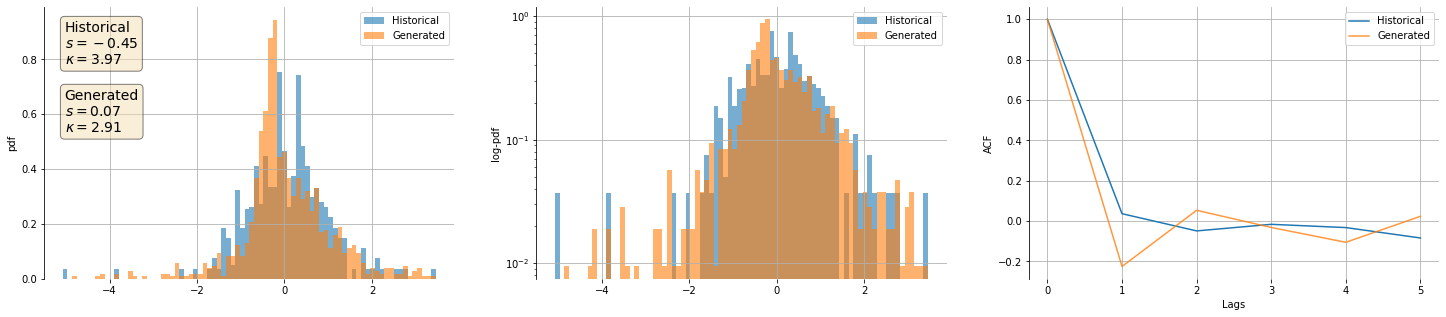

In [ ]:
# Changing size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

# create summary
# create_summary(dataset, base_config.device, algo.G, base_config.p, base_config.q, x_real_test)
# savefig('summary.png', experiment_directory)

# Generation of a pair of sampled paths (fake time series)
x_fake,x_fake2 = create_summary(dataset, base_config.device, algo.G, base_config.p, 1000, x_real_test, one=True)

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
# savefig('summary_long.png', experiment_directory)
# plt.plot(x_fake.cpu().numpy()[0, :2000])
# savefig('long_path.png', experiment_directory)

# # Pickle generator weights, real path and hyperparameters.
pickle_it(x_real, pt.join(pt.dirname(experiment_directory), 'x_real.torch'))
pickle_it(x_real_test, pt.join(pt.dirname(experiment_directory), 'x_real_test.torch'))
pickle_it(x_real_train, pt.join(pt.dirname(experiment_directory), 'x_real_train.torch'))
pickle_it(algo.training_loss, pt.join(experiment_directory, 'training_loss.pkl'))
# pickle_it(algo.G.to('cpu').state_dict(), pt.join(experiment_directory, 'G_weights.torch'))

# Log some results at the end of training
algo.plot_losses()
plt.show()
savefig('losses_fake1.png', experiment_directory)

In [ ]:
# Plotting the generated artificial (fake) time series (path)
# print(x_fake)
plt.plot(x_fake.cpu().numpy()[0, 1:1257], label="fake 1")
# plt.plot(x_fake2.cpu().numpy()[0, :1257], label="fake 2")
# plt.legend(loc="upper left")
plt.show()

In [ ]:
# The inverse transform method is applied to obtain sensible values of log returns (i.e. without necessary scaling for preprocessing)
x_fake_invtransf = pipeline.inverse_transform(x_fake) 
plt.plot(x_fake_invtransf.cpu().numpy()[0, 1:800], label="fake 1")
# plt.plot(x_fake2.cpu().numpy()[0, :1257], label="fake 2")
# plt.legend(loc="upper left")
plt.show()

In [ ]:
# This section is to conduct experiments regarding the predictive score

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.linear_model import LinearRegression

from hyperparameters import SIGCWGAN_CONFIGS
from lib.algos.base import BaseConfig
from lib.algos.base import is_multivariate
from lib.algos.sigcwgan import calibrate_sigw1_metric, sample_sig_fake
from lib.algos.sigcwgan import sigcwgan_loss
from lib.arfnn import SimpleGenerator
from lib.plot import plot_summary, compare_cross_corr
from lib.test_metrics import test_metrics
from lib.utils import load_pickle, to_numpy

warnings.filterwarnings("ignore")


def compute_predictive_score(x_past, x_future, x_fake):
    print("x_fake.shape", x_fake.shape)
    size = x_fake.shape[0]
    X = to_numpy(x_past.reshape(size, -1))
    Y = to_numpy(x_fake.reshape(size, -1))
    print("X.shape", X.shape)
    print("Y.shape", Y.shape)
    size = x_past.shape[0]
    X_test = X.copy()
    Y_test = to_numpy(x_future[:, :1].reshape(size, -1))
    model = LinearRegression() # This is the simple linear regression model to test the usefulness of the artifical data
    model.fit(X, Y)  # TSTR
    r2_tstr = model.score(X_test, Y_test)
    model = LinearRegression()
    model.fit(X_test, Y_test)  # TRTR
    r2_trtr = model.score(X_test, Y_test)
    return dict(r2_tstr=r2_tstr, r2_trtr=r2_trtr, predictive_score=np.abs(r2_trtr - r2_tstr))


def compute_test_metrics(x_fake, x_real):
    res = dict()
    res['abs_metric'] = test_metrics['abs_metric'](x_real)(x_fake).item()
    res['acf_id_lag=1'] = test_metrics['acf_id'](x_real, max_lag=2)(x_fake).item()
    res['kurtosis'] = test_metrics['kurtosis'](x_real)(x_fake).item()
    res['skew'] = test_metrics['skew'](x_real)(x_fake).item()
    if is_multivariate(x_real):
        res['cross_correl'] = test_metrics['cross_correl'](x_real)(x_fake).item()
    return res


In [ ]:
# The real data and generated fake data are stored in order to evaluate the stylized features in a separate script

# Write correct path of the folder to store the data
experiment_dir = "./numerical_results/STOCKS/SPX/seed=0/"
device = x_real.device

x_real0 = load_pickle(os.path.join(os.path.dirname(experiment_dir), 'x_real_test.torch')).to(device)
# x_real0 = x_real_test
x_past0, x_future0 = x_real0[:, :p], x_real0[:, p:p + q]
# x_future0 = x_real0[:, p:p + q]
dim0 = x_real0.shape[-1]

print("x_real0 shape", x_real0.shape)
# print(x_real0)
# print(x_past0)
# print(x_future0)

In [ ]:
# ----------------------------------------------
# Compute predictive score - TSTR (train on synthetic, test on real)
# ----------------------------------------------
with torch.no_grad():
    x_fake01 = algo.G.sample(1, x_past0.to(device))
predict_score_dict = compute_predictive_score(x_past0, x_future0, x_fake01)
# experiment_summary.update(predict_score_dict)
# print(x_fake01.shape)
print(predict_score_dict)
# ----------------------------------------------
# Compute metrics and scores of the unconditional distribution.
# ----------------------------------------------
with torch.no_grad():
    x_fake02 = algo.G.sample(q, x_past0)
test_metrics_dict = compute_test_metrics(x_fake02, x_real0)
# experiment_summary.update(test_metrics_dict)
# print(test_metrics_dict)

In [ ]:
# Function to sample a trajectory from the fitted model
def sample_traj(device, G, lags_past, steps, x_real, one=False):
    with torch.no_grad():
        x_past = x_real[:, :lags_past]
        
        x_p = x_past.clone().repeat(5, 1, 1)
             
        if one:
            x_p = x_p[:1]

        x_fake_future = G.sample(steps, x_p.to(device))

    return x_fake_future

In [ ]:
# Loop to generate M number of sampled paths
M = 1000
list_traj = []
for m in range(M):
    set_seed(m)
    x_fake_m = sample_traj(base_config.device, algo.G, base_config.p, 1257, x_real_test, one=True)
    x_fake_m_invtransf = pipeline.inverse_transform(x_fake_m)
    list_traj.append(x_fake_m_invtransf)
    
#     list_traj.append(x_fake_m)
x_fake_M = torch.cat(list_traj, 0)

print("x_fake_M.shape", x_fake_M.shape)

In [ ]:
# print(x_fake_M.cpu().numpy()[:, :,0].shape)
# plt.plot(x_fake_M.cpu().numpy()[:, :,0].T)
# plt.show()

In [ ]:
# Storing the artificial sampled trajectories (paths)
# pickle_it(x_fake_M, pt.join(pt.dirname(experiment_directory), 'x_fake_M.torch'))
torch.save(x_fake_M, 'x_fake_M.pt')

In [ ]:
# %matplotlib inline
# plt.rcParams['figure.figsize'] = [20, 10]
# # print("log_returns shape", log_returns.shape)
# print("log_returns", log_returns)
# plt.hist(log_returns, 80, density=True, histtype='bar')
# plt.yscale('log')
# plt.show()